## Objective 

The aim of this project is to analyze King County housing data to find out which features that affect the sale price of houses in the area. I shall utilize linear regression model to achieve this. 

## Problem Statement

I have been hired to advice a real estate agency on whether home renovations have any significant impact on the value of homes.

## Data Understanding

The data set being used in this analysis can be accessed in this repository under the file 'kc_house_data.csv'.The other additional dataset explains the meaning of each column of the csv data. For clarity I can rewrite the columns again as: 

* id - Unique ID for each home sold
* date - Date of the home sale
* price - Price of each home sold
* bedrooms - Number of bedrooms
* bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
* sqft_living - Square footage of the apartments interior living space
* sqft_lot - Square footage of the land space
* floors - Number of floors
* waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
* view - An index from 0 to 4 of how good the view of the property was
* condition - An index from 1 to 5 on the condition of the apartment,
* grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.
* sqft_above - The square footage of the interior housing space that is above ground level
* sqft_basement - The square footage of the interior housing space that is below ground level
* yr_built - The year the house was initially built
* yr_renovated - The year of the house’s last renovation
* zipcode - What zipcode area the house is in
* lat - Lattitude
* long - Longitude
* sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
* sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

# Imprting necesary Python Libraries

In [223]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error

C:\Users\admin\AppData\Local\Temp\ipykernel_14668\2134513282.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


# Loading Data
Loading of the file will be done using pandas Library to create a DataFrame as displayed below.

In [224]:
kc= pd.read_csv('kc_house_data.csv')
kc.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


# Data Cleaning

We shall investigate the columns which appear abnormal and clean them. First we will get the summary all the columns of the data and determine the data types.

In [225]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

We note that date should be changed to a DateTime object for easy manipulation and sqft_basement changed to float type of data. In addition some columns have missing values like waterfront, view and yr.renovated. 

In [226]:
# Convert the date column to datetime data type
def change_to_datetime(kc):
    ''' Changes date to DateTime object'''
    kc['date'] = pd.to_datetime(kc['date'])
    return kc

In [227]:
# Apply the changes to the dataset 
kc = change_to_datetime(kc)

In [228]:
kc['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1920.0        1
3480.0        1
2730.0        1
2720.0        1
248.0         1
Name: sqft_basement, Length: 304, dtype: int64

There are many values which are null (?) and almost half the values are 0.00 meaning that there is no basement. We therefore replace the null figures with zero. 

In [229]:
def replace_placeholder(kc):
    '''Replace ? with 0 in sqft_basement and change to float'''
    kc['sqft_basement'] = kc['sqft_basement'].map(lambda x : float(x.replace('?', '0')))
    return kc

In [230]:
kc = replace_placeholder(kc)

In [231]:
kc['sqft_basement'].value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
1920.0        1
3480.0        1
2730.0        1
2720.0        1
248.0         1
Name: sqft_basement, Length: 303, dtype: int64

## Checking Null values

In [232]:
kc.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

The columns with null values are waterfront, view and yr_renovated. 

In [233]:
def fill_null_values(kc):
    ''' Fills null values with 0'''
    return kc.fillna(0)

In [234]:
kc = fill_null_values(kc)

In [235]:
kc.isna().any().any()

False

In [236]:
kc["view"].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
0               63
Name: view, dtype: int64

since almost all the houses have no view (NONE) we replace the missing values with NONE. 

In [237]:
kc["view"] = kc["view"].replace(0, "NONE")
kc["view"].value_counts()

NONE         19485
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

No more null values.


We now want to add columns which will help us determine the months with higher prices as well as the price of houses at different ages.

In [238]:
kc['month_sold'] = kc['date'].dt.month
kc['year_sold'] = kc['date'].dt.year
kc

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,NONE,...,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,10,2014
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,12,2014
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,2,2015
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,12,2014
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509,5,2014
21593,6600060120,2015-02-23,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200,2,2015
21594,1523300141,2014-06-23,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007,6,2014
21595,291310100,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,NONE,...,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287,1,2015


In [239]:
kc['age_when_sold'] = kc['year_sold'] - kc['yr_built']
kc.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,year_sold,age_when_sold
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,NONE,...,1955,0.0,98178,47.5112,-122.257,1340,5650,10,2014,59
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,12,2014,63
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,1933,0.0,98028,47.7379,-122.233,2720,8062,2,2015,82
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,1965,0.0,98136,47.5208,-122.393,1360,5000,12,2014,49
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,1987,0.0,98074,47.6168,-122.045,1800,7503,2,2015,28


In [240]:
selling_age= kc['age_when_sold'].describe()
selling_age

count    21597.000000
mean        43.323286
std         29.377285
min         -1.000000
25%         18.000000
50%         40.000000
75%         63.000000
max        115.000000
Name: age_when_sold, dtype: float64

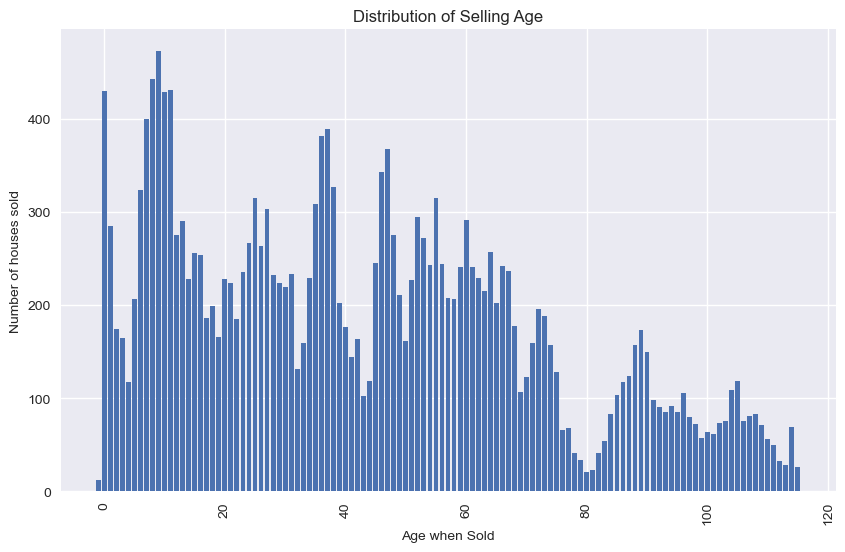

In [241]:
selling_age = kc['age_when_sold']
selling_age_counts = selling_age.value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(selling_age_counts.index, selling_age_counts.values)
plt.xlabel('Age when Sold')
plt.ylabel('Number of houses sold')
plt.title('Distribution of Selling Age')
plt.xticks(rotation=90)
plt.show()

This indicates that most houses ages 0 to 20. This implies that most clients prefer to buy newer houses. 

Before we get into modeling we are going to drop some columns with dates since they will not be suitable when doing regression analysis.

In [242]:
kc = kc.drop(['date', 'yr_built','yr_renovated' ,'year_sold'], axis=1)
kc

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,month_sold,age_when_sold
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,NONE,Average,7 Average,1180,0.0,98178,47.5112,-122.257,1340,5650,10,59
1,6414100192,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,98125,47.7210,-122.319,1690,7639,12,63
2,5631500400,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,98028,47.7379,-122.233,2720,8062,2,82
3,2487200875,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,98136,47.5208,-122.393,1360,5000,12,49
4,1954400510,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,98074,47.6168,-122.045,1800,7503,2,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,360000.0,3,2.50,1530,1131,3.0,NO,NONE,Average,8 Good,1530,0.0,98103,47.6993,-122.346,1530,1509,5,5
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,NO,NONE,Average,8 Good,2310,0.0,98146,47.5107,-122.362,1830,7200,2,1
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,NO,NONE,Average,7 Average,1020,0.0,98144,47.5944,-122.299,1020,2007,6,5
21595,291310100,400000.0,3,2.50,1600,2388,2.0,0,NONE,Average,8 Good,1600,0.0,98027,47.5345,-122.069,1410,1287,1,11


View, condition and grade are categorical variables. We can assign each the categories in those columns a numerical value to make it easy to do regression analysis. We are going to convert them into a dictionary and apply them to the main dataframe. 

In [243]:
kc["grade"]

0            7 Average
1            7 Average
2        6 Low Average
3            7 Average
4               8 Good
             ...      
21592           8 Good
21593           8 Good
21594        7 Average
21595           8 Good
21596        7 Average
Name: grade, Length: 21597, dtype: object

In [244]:
kc["grade"].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [245]:
kc["condition"]

0          Average
1          Average
2          Average
3        Very Good
4          Average
           ...    
21592      Average
21593      Average
21594      Average
21595      Average
21596      Average
Name: condition, Length: 21597, dtype: object

In [246]:
kc["condition"].value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [248]:
kc["view"].value_counts()

NONE         19485
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

Creating Keys for the Categorical Variables:

In [249]:
# Creating key for house condition

condition_key = {'Poor':1.0 , 'Fair':2.0 , 'Average':3.0 , 'Good':4.0 , 'Very Good':5.0}

In [250]:
# Creating grade key

grade_key = {'3 Poor':3.0,
             '4 Low':4.0,
             '5 Fair':5.0,
             '6 Low Average':6.0,
             '7 Average': 7.0,
             '8 Good':8.0,
             '9 Better':9.0,
             '10 Very Good':10.0,
             '11 Excellent':11.0,
             '12 Luxury': 12.0,
             '13 Mansion':13.0}

In [251]:
# Creating view key
view_key = {'NONE':1.0 , 'AVERAGE':2.0 , 'GOOD':3.0 , 'FAIR':4.0 , 'EXCELLENT':5.0}

In [254]:
# Use .replace method to replace string to numerical data
kc['condition'] = kc['condition'].replace(condition_key)

In [255]:
kc['grade'] = kc['grade'].replace(grade_key)

In [256]:
kc['view'] = kc['view'].replace(view_key)

In [257]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   price          21597 non-null  float64
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  object 
 8   view           21597 non-null  float64
 9   condition      21597 non-null  float64
 10  grade          21597 non-null  float64
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  float64
 13  zipcode        21597 non-null  int64  
 14  lat            21597 non-null  float64
 15  long           21597 non-null  float64
 16  sqft_living15  21597 non-null  int64  
 17  sqft_lot15     21597 non-null  int64  
 18  month_

All the columns now are in numerics

In [259]:
kc.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,21597.0,4.580474e+09,2.876736e+09,1.000102e+06,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21597.0,5.402966e+05,3.673681e+05,7.800000e+04,3.220000e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,21597.0,3.373200e+00,9.262989e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21597.0,2.115826e+00,7.689843e-01,5.000000e-01,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,21597.0,2.080322e+03,9.181061e+02,3.700000e+02,1.430000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,21597.0,1.509941e+04,4.141264e+04,5.200000e+02,5.040000e+03,7.618000e+03,1.068500e+04,1.651359e+06
floors,21597.0,1.494096e+00,5.396828e-01,1.000000e+00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
view,21597.0,1.195907e+00,6.873193e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00
condition,21597.0,3.409825e+00,6.505456e-01,1.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
grade,21597.0,7.657915e+00,1.173200e+00,3.000000e+00,7.000000e+00,7.000000e+00,8.000000e+00,1.300000e+01


We can remove the id column since it is no needed in correlation. Also, lat and long columns are not essential since from our description above their minimum and maximum values are too close to each other. So we remove the said columns. 

In [260]:
kc = kc.drop(['id'], axis=1)

In [261]:
kc = kc.drop(['lat'], axis=1)

In [262]:
kc = kc.drop(['long'], axis=1)

In [263]:
kc.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,21597.0,540296.573506,367368.140101,78000.0,322000.00,450000.00,645000.0,7700000.0
bedrooms,21597.0,3.373200,0.926299,1.0,3.00,3.00,4.0,33.0
bathrooms,21597.0,2.115826,0.768984,0.5,1.75,2.25,2.5,8.0
sqft_living,21597.0,2080.321850,918.106125,370.0,1430.00,1910.00,2550.0,13540.0
sqft_lot,21597.0,15099.408760,41412.636876,520.0,5040.00,7618.00,10685.0,1651359.0
floors,21597.0,1.494096,0.539683,1.0,1.00,1.50,2.0,3.5
view,21597.0,1.195907,0.687319,1.0,1.00,1.00,1.0,5.0
condition,21597.0,3.409825,0.650546,1.0,3.00,3.00,4.0,5.0
grade,21597.0,7.657915,1.173200,3.0,7.00,7.00,8.0,13.0
sqft_above,21597.0,1788.596842,827.759761,370.0,1190.00,1560.00,2210.0,9410.0


We now check for outliers

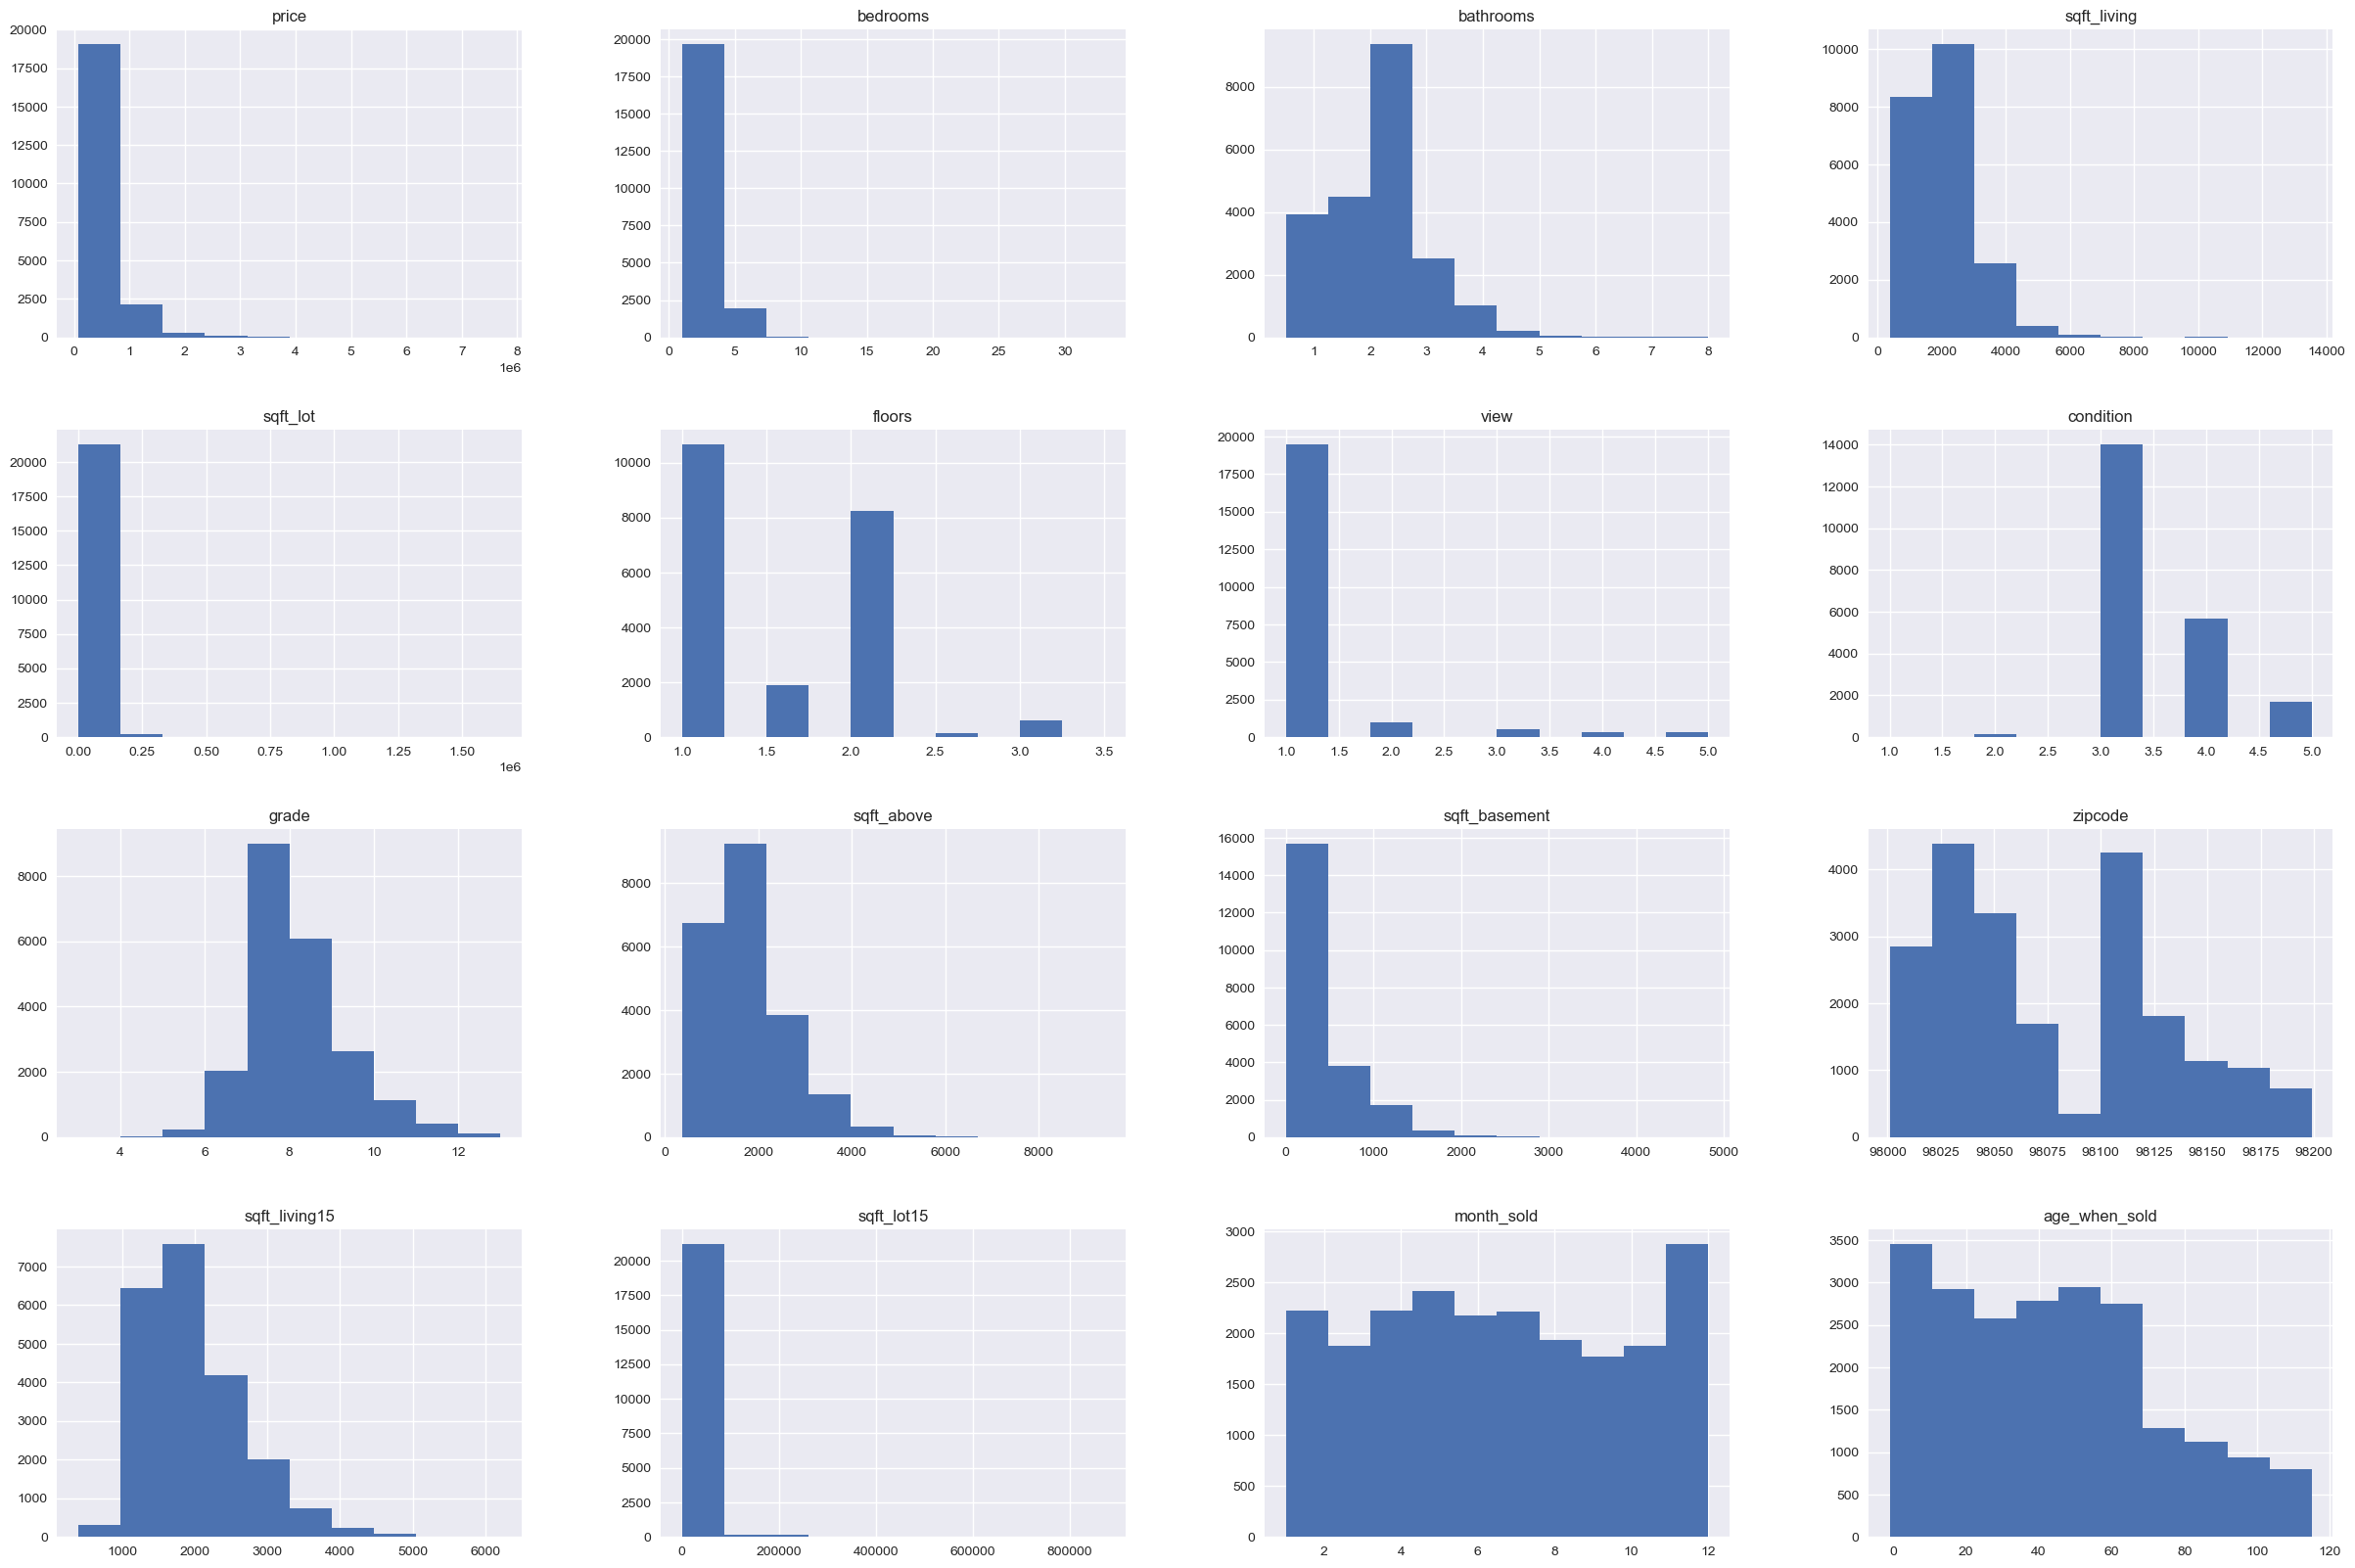

In [276]:
kc.hist(figsize  = [30, 20]); 

Most of the variables show a skewed distribution. Will will use z score to do away with rows with outliers

In [268]:
kc_numerical = ['price', 'sqft_living','sqft_living15', 'sqft_lot','sqft_lot15','sqft_above', 'sqft_basement','age_when_sold']
kc_numerical_categorical = ['bedrooms', 'bathrooms', 'floors']
kc_categorical = ['view','condition','grade','month_sold','zipcode']

In [269]:
kc.shape

(21597, 17)

In [271]:
z = np.abs(stats.zscore(kc[kc_numerical+kc_numerical_categorical]))
z.head(10)

,price,sqft_living,sqft_living15,sqft_lot,sqft_lot15,sqft_above,sqft_basement,age_when_sold,bedrooms,bathrooms,floors
0,0.866716,0.980652,0.943676,0.228182,0.260627,0.735251,0.649637,0.533646,0.402903,1.451073,0.915552
1,0.006252,0.533369,0.432887,0.189739,0.187700,0.460776,0.259847,0.669809,0.402903,0.174486,0.937431
2,0.980773,1.427234,1.070292,0.123139,0.172190,1.230575,0.649637,1.316582,1.482493,1.451073,0.915552
3,0.173409,0.131057,0.914488,0.243878,0.284459,0.892305,1.419440,0.193239,0.676687,1.149821,0.915552
4,0.082471,0.436040,0.272353,0.169503,0.192686,0.131197,0.649637,0.521615,0.402903,0.150626,0.915552
5,1.877461,3.637657,4.047461,2.096766,3.269500,2.538722,2.829141,1.032226,0.676687,3.100491,0.915552
6,0.769809,0.397917,0.366863,0.199953,0.217765,0.088913,0.649637,0.827982,0.402903,0.174486,0.937431
7,0.676303,1.111359,0.491263,0.130118,0.111729,0.880224,0.649637,0.295361,0.402903,0.800849,0.915552
8,0.846028,0.327118,0.301541,0.184233,0.170320,0.892305,1.010172,0.397483,0.402903,1.451073,0.915552
9,0.591509,0.207303,0.588691,0.206208,0.190230,0.122506,0.649637,1.066266,0.402903,0.499597,0.937431


In [272]:
z.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,21597.0,0.637055,0.770836,0.000282,0.253965,0.509845,0.770897,19.489630
sqft_living,21597.0,0.760370,0.649505,0.000351,0.315524,0.642993,1.035113,12.482156
sqft_living15,21597.0,0.782465,0.622709,0.003824,0.340594,0.676255,1.055698,6.163587
sqft_lot,21597.0,0.333853,0.942647,0.000010,0.143665,0.199446,0.263269,39.512033
sqft_lot15,21597.0,0.370406,0.928891,0.000063,0.146305,0.218205,0.307024,31.474946
sqft_above,21597.0,0.773420,0.633909,0.000721,0.352046,0.666155,1.001034,9.207478
sqft_basement,21597.0,0.818111,0.575073,0.006177,0.649637,0.649637,0.649637,10.309650
age_when_sold,21597.0,0.836408,0.548120,0.011005,0.385452,0.759900,1.202429,2.439925
bedrooms,21597.0,0.791959,0.610588,0.402903,0.402903,0.676687,0.676687,31.984801
bathrooms,21597.0,0.799251,0.601011,0.150626,0.475738,0.499597,1.451073,7.652055


In [273]:
# new dataframe where all z scores are less than 3
new_kc= kc[(z<3).all(axis=1)]

In [274]:
new_kc.shape

(20239, 17)

We have eliminted like a thousand rows from our data set. Now we can figure out if the distribution of our new dataframe has improved towards becoming normal. 

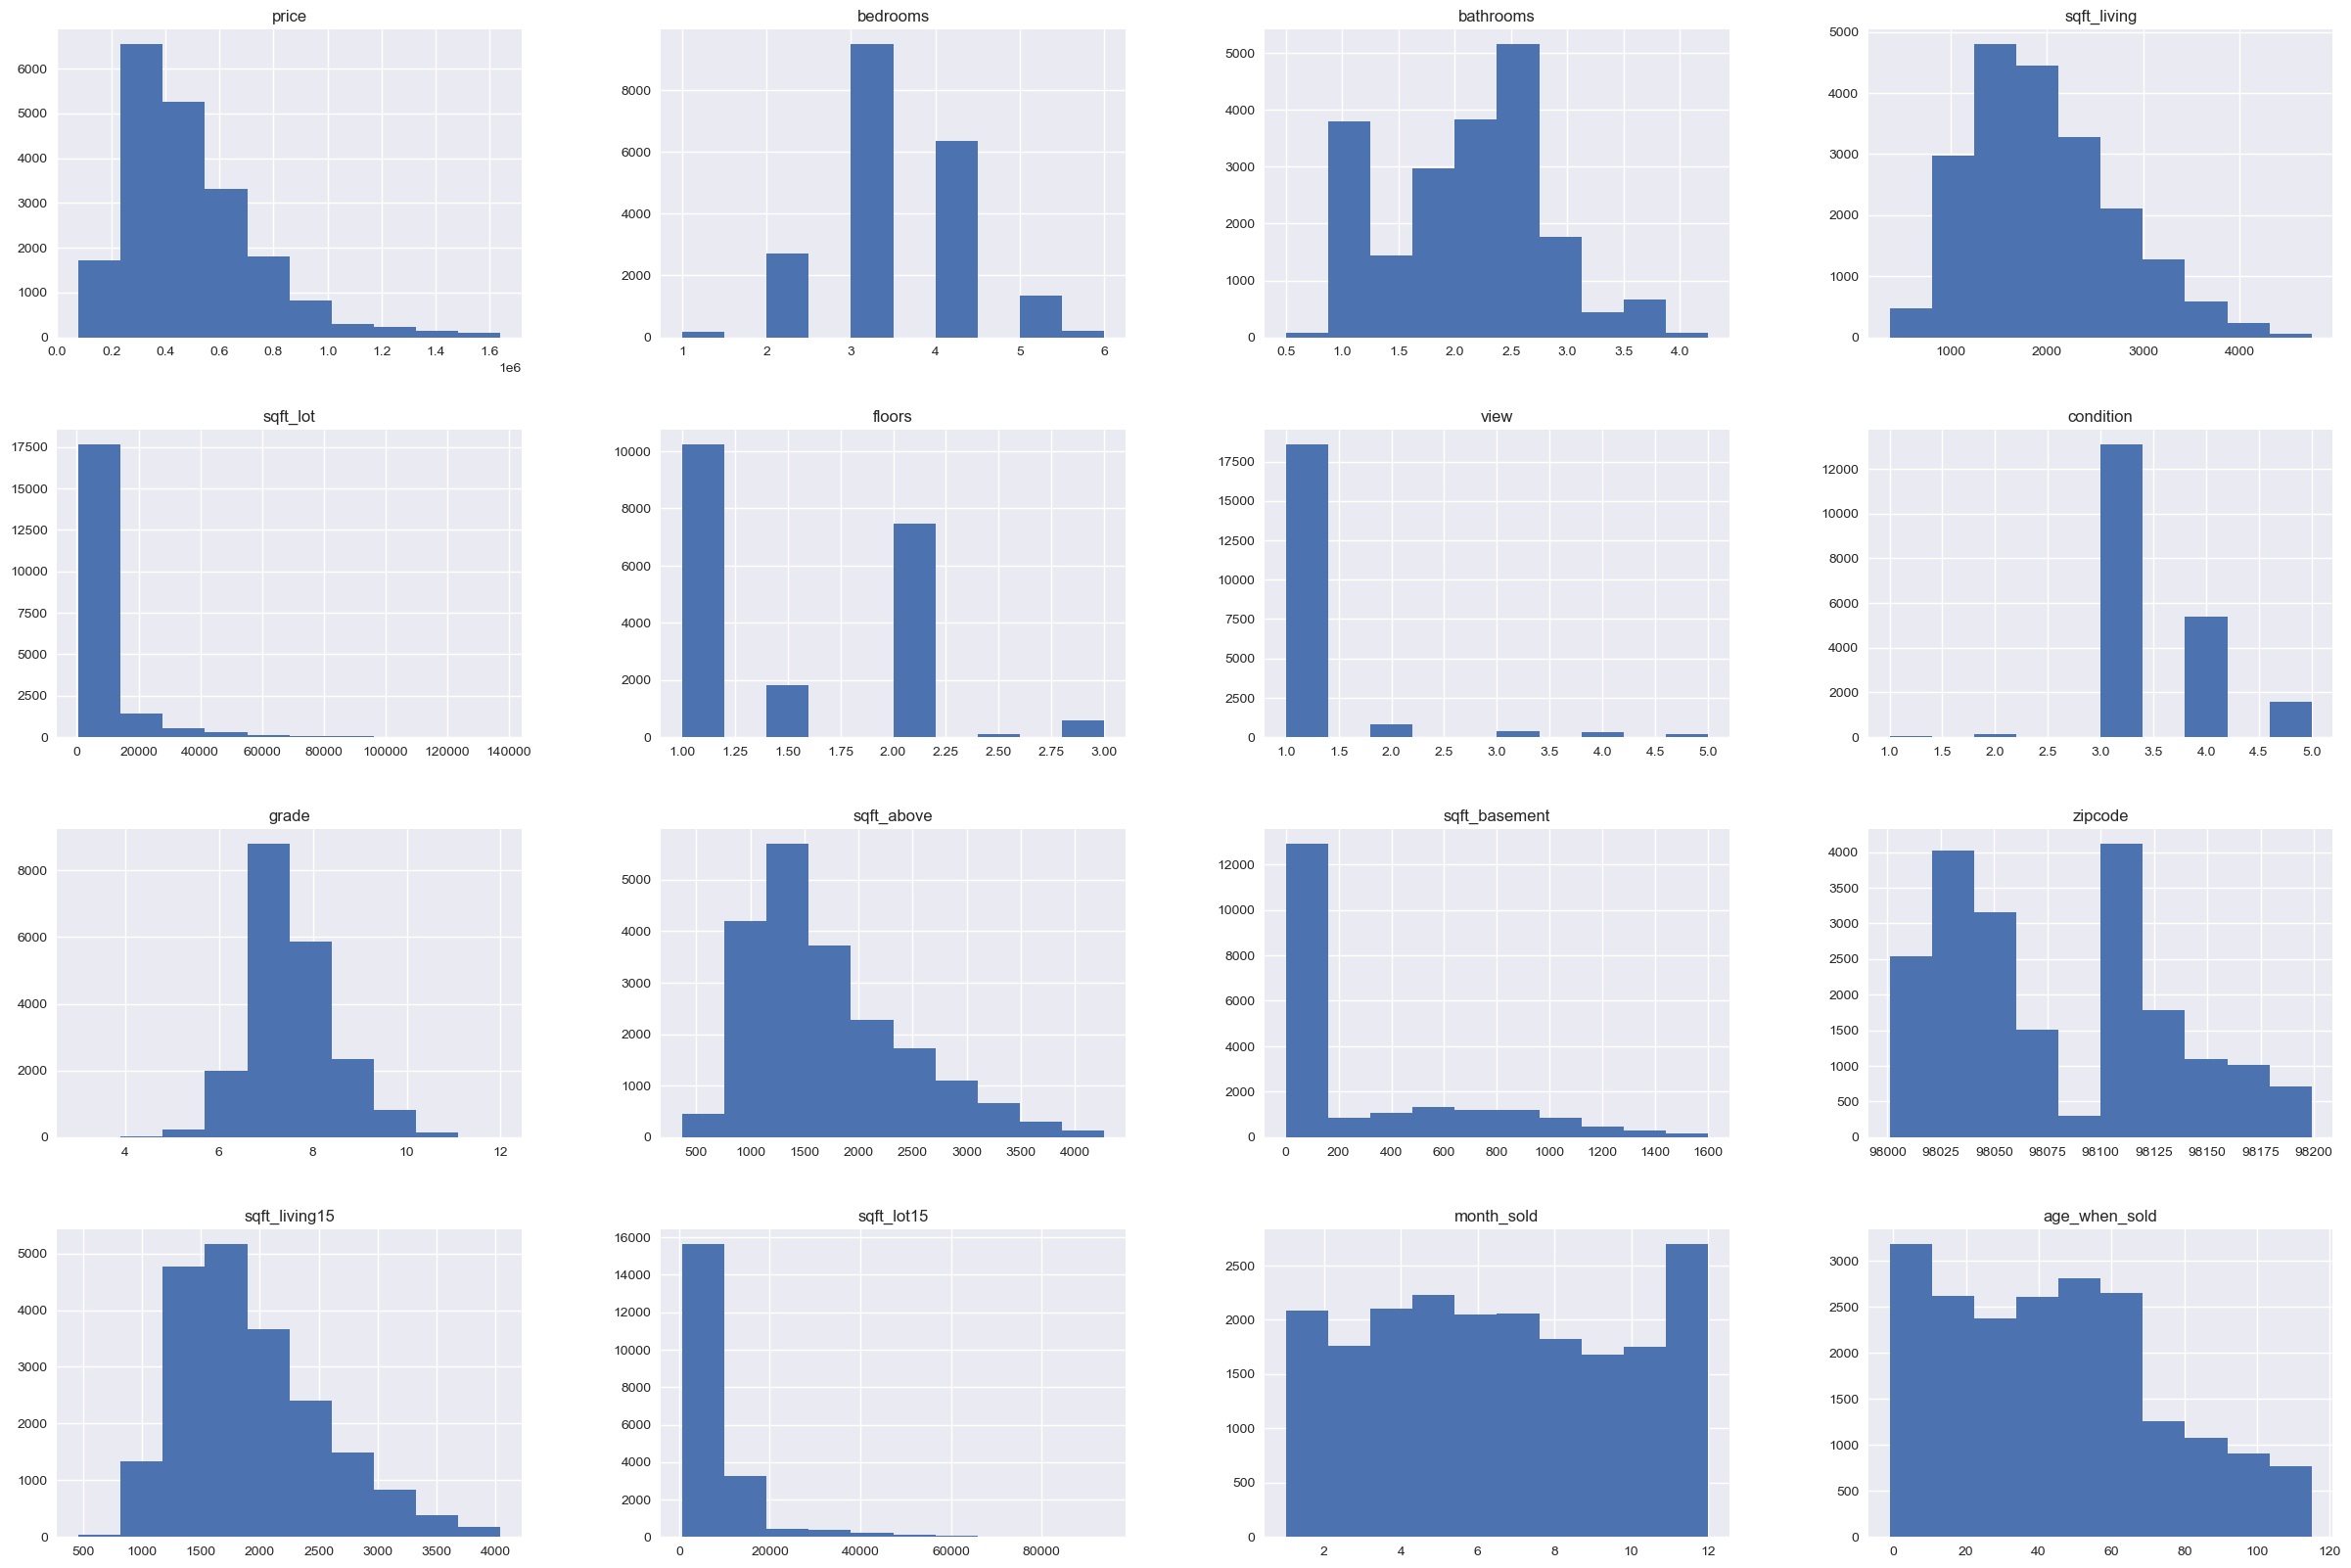

In [275]:
new_kc.hist(figsize  = [30, 20]); 

In [277]:
#copy the outlier-free dataframe back as our original dataframe

kc_df = new_kc.copy()

In [278]:
kc_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,20239.0,493450.170512,245404.159896,78000.0,315000.0,439950.0,613000.0,1640000.00
bedrooms,20239.0,3.322644,0.855654,1.0,3.0,3.0,4.0,6.00
bathrooms,20239.0,2.048174,0.694736,0.5,1.5,2.0,2.5,4.25
sqft_living,20239.0,1966.681605,748.649385,370.0,1400.0,1860.0,2430.0,4750.00
sqft_lot,20239.0,10076.432729,11809.289632,520.0,5000.0,7412.0,10030.5,137214.00
floors,20239.0,1.480631,0.538121,1.0,1.0,1.0,2.0,3.00
view,20239.0,1.154059,0.598514,1.0,1.0,1.0,1.0,5.00
condition,20239.0,3.411532,0.650106,1.0,3.0,3.0,4.0,5.00
grade,20239.0,7.547656,1.046828,3.0,7.0,7.0,8.0,12.00
sqft_above,20239.0,1700.185681,706.902898,370.0,1170.0,1520.0,2100.0,4270.00


The data is now ready for regression.

## Data Modeling

Our target model is price. So first we can check how price correlates with the other variables.